In [23]:
###--- import packages ---###

import numpy as np
import matplotlib.pyplot as plt
from PDE_FIND import *
import pandas as pd
import pickle
import matplotlib 
font = {'family': 'Arial'}
matplotlib.rc('font', **font)
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import scipy.signal
import re

In [30]:
###--- import data ---###

data = pd.read_csv('simulated-data.csv')
# Temperatures
T = data.values[:,0]

# Logisitc function fitting params
A = data.values[:,1]
Ea = data.values[:,2]
Uo = data.values[:,3]
K = data.values[:,4]
M = data.values[:,5]

# Simulated noise-free curves
rml = data.values[:,6:]

#time vector
time = list(data.columns)[6:]
time = [float(s[5:]) for s in time]

In [31]:
###--- PDE-FIND Parameters ---###
dt = time[1] - time[0] 
dx = T[2] - T[1] 

D0 = 0 # only applicable for space derivative (not applicable in our case)
tol = 1 # threshold for STRidge
lam = 10**-5 # weight for regularization
method = 'FDConv' # method for numerical differentiation - Finite difference with smoothing
N = 10

###--- odeint parameters ---###
atol0 = 10e-7
rtol0 = 10-10

In [133]:
###--- PDE-FIND Library Polynomial Order ---###
## You can change this prarameter between 1 to 5
P0 = 2 # max order of polynomial 

## No Noise

In [134]:
solavg = []
for i in range(len(T)): # to run for all temperatures
    
    # tiling the average data to make a matrix -> format that PDE-Find accepts
    pde_data = np.multiply(np.tile(rml[i][:], (N, 1)),1)
    
    #build library
    Ut,R,rhs_des = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # run pde-find
    solavg.append(np.real(TrainSTRidge(R,Ut,lam,tol,normalize = 2)))
    
solavg = np.array(solavg)
# run PDE-FIND
solavg = []
for i in range(len(T)): # to run for all temperatures
    
    # tiling the average data to make a matrix -> format that PDE-Find accepts
    pde_data = np.multiply(np.tile(rml[i][:], (N, 1)),1)
    
    #build library
    Ut,R,rhs_des = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # run pde-find
    solavg.append(np.real(TrainSTRidge(R,Ut,lam,tol,normalize = 2)))
    
solavg = np.array(solavg)

In [135]:
###--- Function to estimate derivative from the equation identified by PDE-FIND ---###

def pdediffeq(u,t,coefs):
    if P0 == 1:
        dudt =  coefs[0] + np.multiply(coefs[1],u) #+ np.multiply(coefs[2],np.power(u,2))# + np.multiply(coefs[3],np.power(u,3))# + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5))
    if P0 == 2:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2))# + np.multiply(coefs[3],np.power(u,3))# + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5)) 
    if P0 == 3:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3))# + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5)) 
    if P0 == 4:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3)) + np.multiply(coefs[4],np.power(u,4))# + np.multiply(coefs[5],np.power(u,5)) 
    if P0 == 5:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3)) + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5)) 
    
    return np.reshape(dudt,(-1,))

In [136]:
# function to choose best initial condition
from scipy.optimize import fminbound
def bestUo(func, sol, time, i):
    def fit_mse(U0):
        curve = np.reshape(odeint(func, U0, np.reshape(time,(-1)), args=(sol,), atol = atol0, rtol = rtol0), (len(time)))
        return mse(rml[i],curve)
    
    U0 = rml[i][0]
    Uopt = fminbound(fit_mse, U0-5, U0+5, xtol=1e-3, disp=False)
    return Uopt

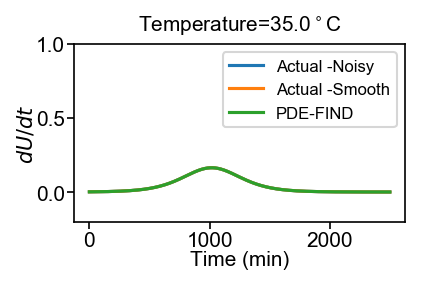

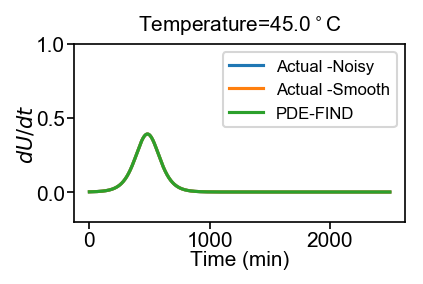

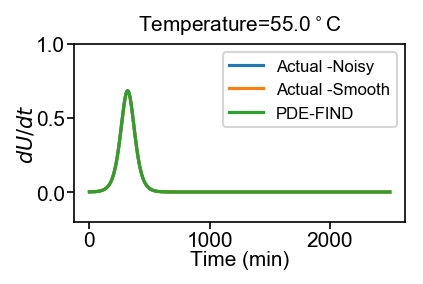

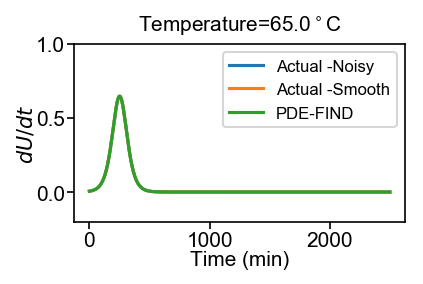

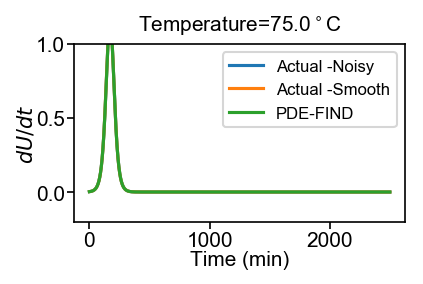

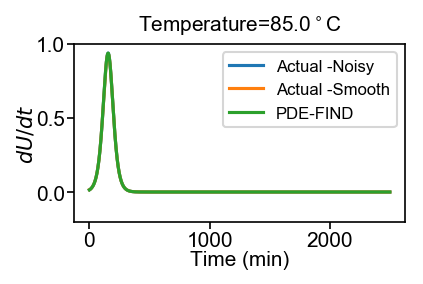

In [137]:
###--- comparing the actual derivative with PDE-FIND estimate ---###

mae_alld = [] # vector to store the MAE between actual derivative and PDE-FIND estimate

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2), dpi=150)
    ax.tick_params(axis='both', which='major', pad=1)
    plt.title("Temperature="+str(T[i]) + "$^\circ$C", fontsize = 10)
    
    # estimate actual derivative through PDE-FIND
    pde_data = np.tile(rml[i][:],(1,1))
    Ut_actual,_,_ = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # First, the actual derivative needs to be smoothened. we use the savitzky-golay filter
    Ut_smooth = scipy.signal.savgol_filter(Ut_actual.reshape((-1)), 235, 5) 
    
    # PDE-FIND estimate
    Ut_pdefind = pdediffeq(rml[i], time, solavg[i])
    
    
    plt.plot(time[:],Ut_actual[:], label = 'Actual -Noisy')
    plt.plot(time[:], Ut_smooth[:], label = 'Actual -Smooth')
    plt.plot(time[:], Ut_pdefind[:], label = 'PDE-FIND')
    
    plt.xlabel("Time (min)", fontsize = 10, labelpad = 0)
    plt.ylabel("$dU/dt$", fontsize = 10, labelpad = 0)
    plt.ylim(-0.2,1)
    plt.legend(fontsize = 8)
    
    # calculate MAE error
    mae_alld.append(mae(Ut_smooth,Ut_pdefind))
    
    plt.tight_layout()

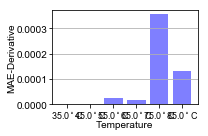

In [138]:
###--- bar-plot :comparing the actual derivative with PDE-FIND estimate ---###

fig, ax = plt.subplots(1, 1, figsize = (3,2))
ax.tick_params(axis='both', which='major', pad=1)
plt.bar(range(len(T)),np.divide(mae_alld,1),
        width = 0.8,
        color = 'b',
        align ='center',
        alpha=0.5,
        ecolor='black',
        capsize=14)

ax.set_ylabel('MAE-Derivative', fontsize = 10, labelpad = 0)
ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

ax.set_xticks(range(len(T)))
ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
ax.set_title('')
ax.yaxis.grid(True)
plt.tight_layout()

c:\users\richa\anaconda3\envs\pdefind\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


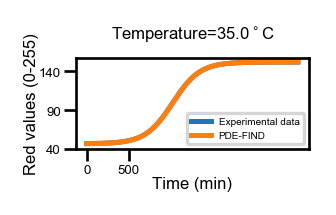

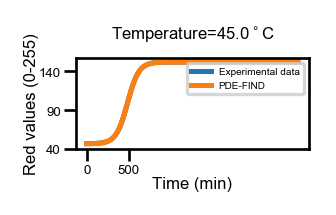

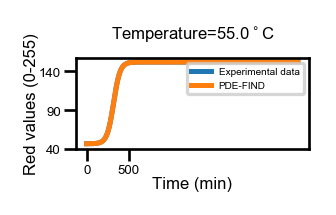

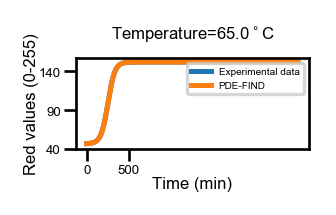

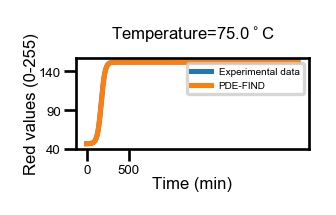

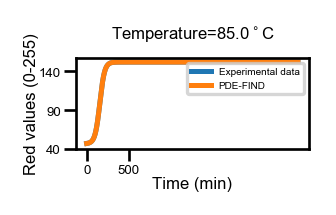

In [139]:
mae_alli = [] # vector to store the MAE between actual data and PDE-FIND estimate integrated curve

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (1.5,1), dpi = 240)
    ax.tick_params(axis='both', which='major', pad=1)
    
    # integrate PDE-FIND equation with odeint
    U0 = bestUo(pdediffeq, solavg[i], time, i) # inital conditions at t=0
    curve = np.reshape(odeint(pdediffeq, U0, np.reshape(time,(-1)), args=(solavg[i],), atol = atol0, rtol = rtol0), (len(time)))

    plt.title("Temperature="+str(T[i])+ "$^\circ$C", fontsize = 5)
    plt.plot(time[:],rml[i][:], label = "Experimental data")
    plt.plot(time[:],curve[:], label="PDE-FIND")
    plt.ylabel("Red values (0-255)", fontsize = 5, labelpad = 0)
    plt.xlabel("Time (min)", fontsize = 5, labelpad = 0)
    plt.legend(fontsize = 3)
    plt.yticks([40,90,140], fontsize = 4)
    plt.xticks([0,500], fontsize = 4)
    
    mae_alli.append(mae(rml[i],curve))
    
    plt.tight_layout()

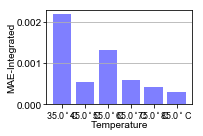

In [140]:
###--- bar-plot: comparing the actual data with PDE-FIND's estimate of integrated curve ---###

fig, ax = plt.subplots(1, 1, figsize = (3,2))
ax.tick_params(axis='both', which='major', pad=1)
plt.bar(range(len(T)),np.divide(mae_alli,1),
        width = 0.8,
        color = 'b',
        align ='center',
        alpha=0.5,
        ecolor='black',
        capsize=14)

ax.set_ylabel('MAE-Integrated', fontsize = 10, labelpad = 0)
ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

ax.set_xticks(range(len(T)))
ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
ax.set_title('')
ax.yaxis.grid(True)
plt.tight_layout()

## With Noise

In [141]:
noise = [0,0.01, 0.02, 0.03, 0.04, 0.05]

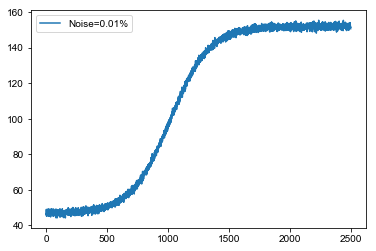

In [142]:
# plot noisy data
for j in [1]:#range(len(noise)):
    
    for i in [0]:#range(len(T)):
        pde_data = np.multiply(np.tile(rml[i][:], (1, 1)),1)
        pde_datan = np.multiply(pde_data, noise[j])
#         pde_datan = pde_datan + np.multiply(pde_datan, np.random.randn(pde_data.shape[0],pde_data.shape[1]))
#         pde_datan = pde_data + noise[j]*np.std(pde_data)*np.random.randn(pde_data.shape[0],pde_data.shape[1])
        pde_datan = pde_data + noise[j]*np.mean(pde_data)*np.random.randn(pde_data.shape[0],pde_data.shape[1])

        
        plt.plot(time,pde_datan.T, label = 'Noise='+str(noise[j])+'%')
plt.legend()

In [143]:
sol_all_n = np.zeros((len(T),len(noise),P0+1))

for j in range(len(noise)):
    
    for i in range(len(T)):
        pde_data = np.multiply(np.tile(rml[i][:], (N, 1)),1)
#         pde_datan = pde_data + noise[j]*np.std(pde_data)*np.random.randn(pde_data.shape[0],pde_data.shape[1])
        pde_datan = pde_data + noise[j]*np.mean(pde_data)*np.random.randn(pde_data.shape[0],pde_data.shape[1])

        Ut,R,rhs_des = build_linear_system(pde_datan, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
        sol_all_n[i,j,:] = np.real(TrainSTRidge(R,Ut,lam,tol,normalize = 2)).reshape((-1))

In [146]:
sol_all_n.shape

(6L, 6L, 3L)

## Plotting Derivatives and Integrations

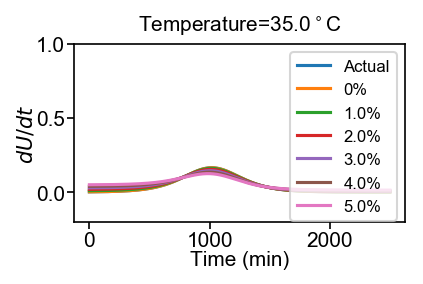

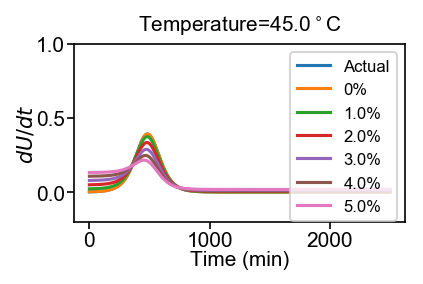

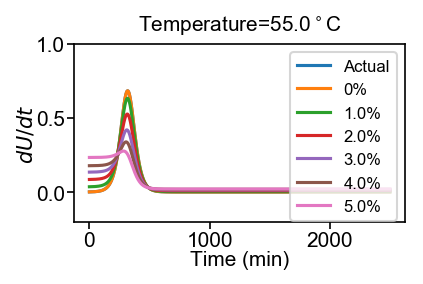

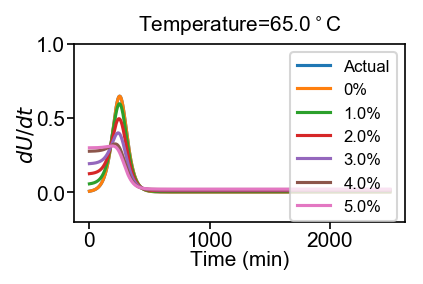

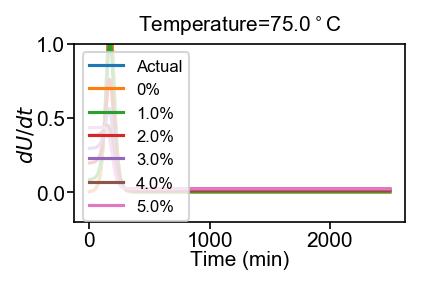

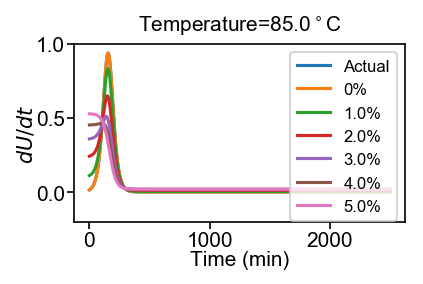

In [147]:
###--- comparing the actual derivative with PDE-FIND estimate ---###

mae_alld = np.zeros((len(T), len(noise))) # vector to store the MAE between actual derivative and PDE-FIND estimate

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2), dpi=150)
    ax.tick_params(axis='both', which='major', pad=1)
    plt.title("Temperature="+str(T[i]) + "$^\circ$C", fontsize = 10)
    
    # estimate actual derivative through PDE-FIND
    pde_data = np.tile(rml[i][:],(1,1))
    Ut_actual,_,_ = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    Ut_actual = Ut_actual.real
    
    # plot actual derivative
    plt.plot(time[:],Ut_actual[:], label = 'Actual')

    for j in range(len(noise)):

        # PDE-FIND estimate
        Ut_pdefind = pdediffeq(rml[i], time, sol_all_n[i][j])
        plt.plot(time[:], Ut_pdefind[:], label = str(noise[j]*100)+'%')
        
        # calculate MAE error
        mae_alld[i][j] = mae(Ut_actual,Ut_pdefind)

    plt.xlabel("Time (min)", fontsize = 10, labelpad = 0)
    plt.ylabel("$dU/dt$", fontsize = 10, labelpad = 0)
    plt.ylim(-0.2,1)
    plt.legend(fontsize = 8)

    plt.tight_layout()

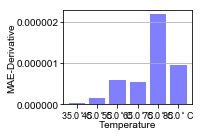

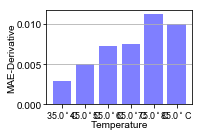

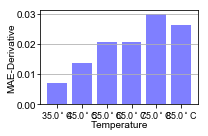

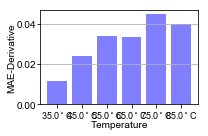

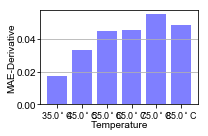

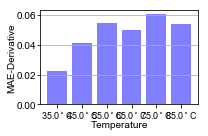

In [148]:
###--- bar-plot :comparing the actual derivative with PDE-FIND estimate ---###
for j in range(len(noise)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2))
    ax.tick_params(axis='both', which='major', pad=1)
    plt.bar(range(len(T)),np.divide(mae_alld[:,j],1),
            width = 0.8,
            color = 'b',
            align ='center',
            alpha=0.5,
            ecolor='black',
            capsize=14)

    ax.set_ylabel('MAE-Derivative', fontsize = 10, labelpad = 0)
    ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

    ax.set_xticks(range(len(T)))
    ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
    ax.set_title('')
    ax.yaxis.grid(True)
    plt.tight_layout()

Text(0.5,34.45,'Noise (%)')

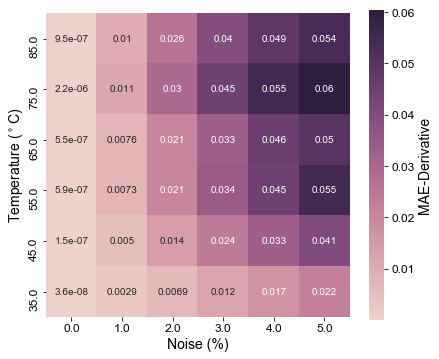

In [150]:
###--- heatmap of MAEs ---###

import seaborn as sns
# data = {"Temperature":Tall, "Noise":Nall,"MAE":errall}
# dataf  = pd.DataFrame(data)
#dataf = dataf.pivot("Temperature", "Noise", "MAE")
#ax = sns.heatmap(dataf, annot=True, fmt="d")
plt.figure(figsize = (6.8,5.7))

ax = sns.heatmap(np.flip(mae_alld,axis=0),annot=True,square=True,cmap=sns.cubehelix_palette(as_cmap=True),cbar_kws={'label': 'MAE-Derivative'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
ax.set_aspect("equal")
ax.set_xticklabels(np.multiply(noise,100),fontsize=12)
ax.set_yticklabels(np.flip(T),fontsize=12)
ax.set_ylabel("Temperature ($^\circ$C)",fontsize=14)
ax.set_xlabel("Noise (%)",fontsize=14)
#plt.savefig('heatmap-bgm-allT-allN-100.png',dpi=1200,bbox_inches="tight",transparent=True)

In [104]:
sol_all_n[i][j]

array([ 3.37711461e-02,  9.02263797e-03, -1.75913878e-04,  0.00000000e+00,
        1.42570196e-08, -5.99807070e-11])

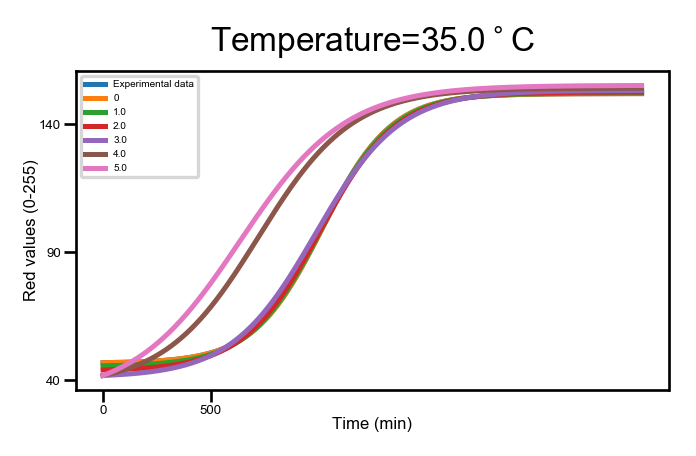

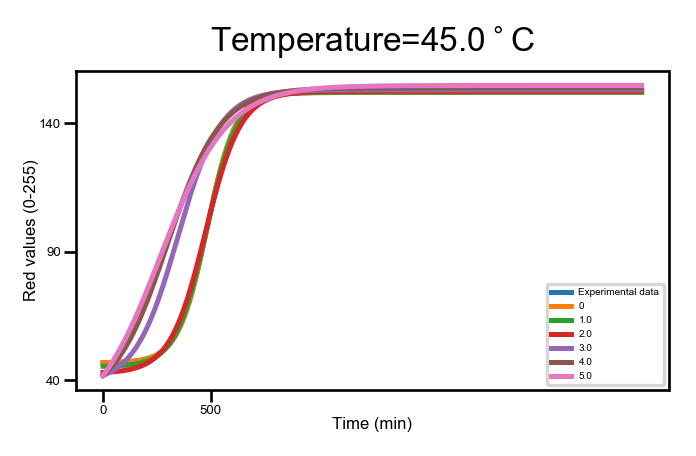

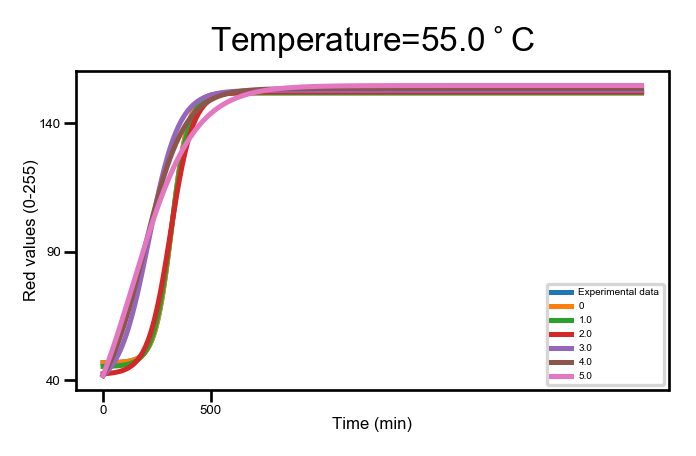

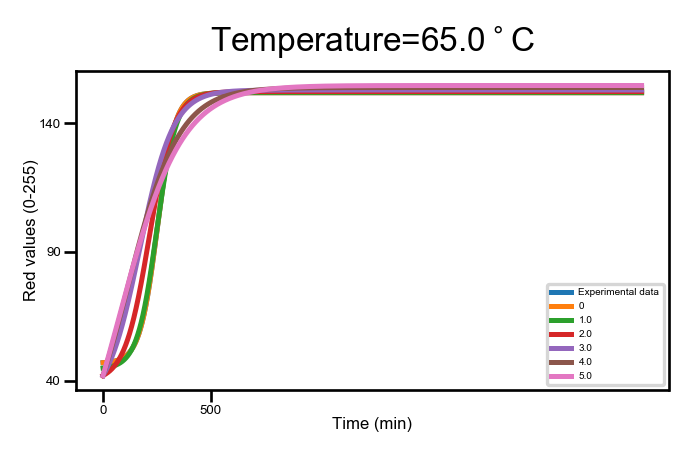

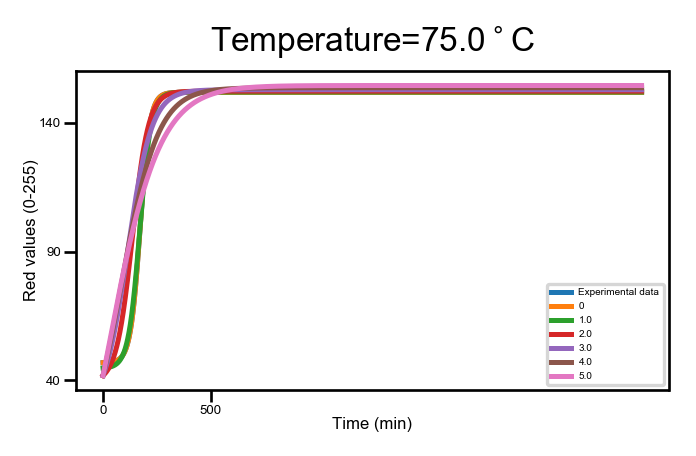

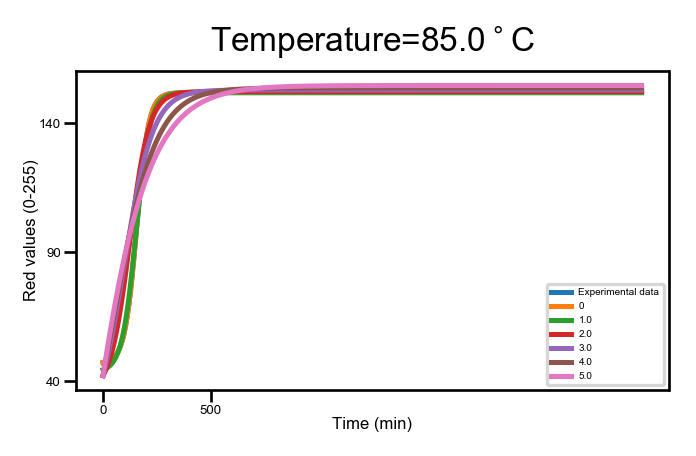

In [151]:
mae_alli = np.zeros((len(T), len(noise))) # vector to store the MAE between actual data and PDE-FIND estimate integrated curve

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2), dpi = 240)
    ax.tick_params(axis='both', which='major', pad=1)
    plt.title("Temperature="+str(T[i]) + "$^\circ$C", fontsize = 10)
    
    # Plot experimental data
    plt.plot(time[:],rml[i][:], label = "Experimental data")
    
    for j in range(len(noise)):

        # integrate PDE-FIND equation with odeint
        U0 = bestUo(pdediffeq, sol_all_n[i][j], time,i) # inital conditions at t=0
        curve = np.reshape(odeint(pdediffeq, U0, np.reshape(time,(-1)), args=(sol_all_n[i][j],), atol = atol0, rtol = rtol0), (len(time)))

        plt.plot(time[:],curve[:], label=str(noise[j]*100))
        plt.ylabel("Red values (0-255)", fontsize = 5, labelpad = 0)
        plt.xlabel("Time (min)", fontsize = 5, labelpad = 0)
        plt.legend(fontsize = 3)
        plt.yticks([40,90,140], fontsize = 4)
        plt.xticks([0,500], fontsize = 4)

        mae_alli[i][j] = mae(rml[i],curve)

    plt.tight_layout()

In [124]:
len(noise)

6

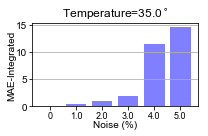

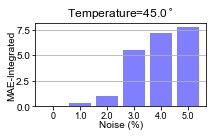

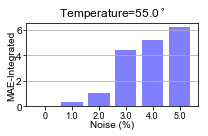

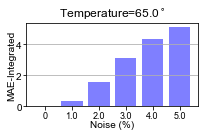

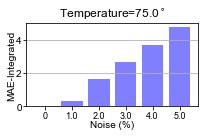

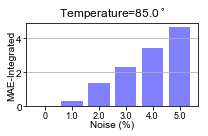

In [152]:
###--- bar-plot: comparing the actual data with PDE-FIND's estimate of integrated curve ---###

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2))
    ax.tick_params(axis='both', which='major', pad=1)
    plt.bar(range(len(noise)),np.divide(mae_alli[i],1),
            width = 0.8,
            color = 'b',
            align ='center',
            alpha=0.5,
            ecolor='black',
            capsize=14)

    ax.set_ylabel('MAE-Integrated', fontsize = 10, labelpad = 0)
    ax.set_xlabel('Noise (%)', fontsize = 10, labelpad = 0)

    ax.set_xticks(range(len(noise)))
    ax.set_xticklabels([str(noise[k]*100) for k in range(len(noise))], fontsize = 9)
    ax.set_title('Temperature='+str(T[i])+'$^\circ$')
    ax.yaxis.grid(True)
    plt.tight_layout()

Text(0.5,34.45,'Noise (%)')

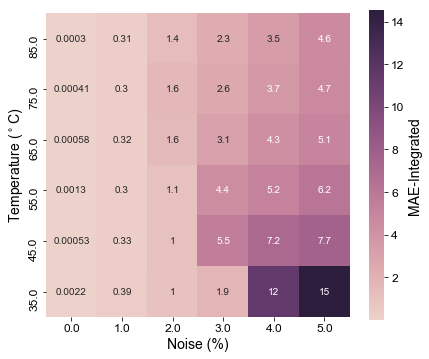

In [154]:
###--- heatmap of MAEs between Actual simulated curve and that obtianed after integrating the DE outputted by PDE-FIND---###

import seaborn as sns
# data = {"Temperature":Tall, "Noise":Nall,"MAE":errall}
# dataf  = pd.DataFrame(data)
#dataf = dataf.pivot("Temperature", "Noise", "MAE")
#ax = sns.heatmap(dataf, annot=True, fmt="d")
plt.figure(figsize = (6.8,5.7))

ax = sns.heatmap(np.flip(mae_alli,axis=0),annot=True,square=True,cmap=sns.cubehelix_palette(as_cmap=True),cbar_kws={'label': 'MAE-Integrated'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
ax.set_aspect("equal")
ax.set_xticklabels(np.multiply(noise,100),fontsize=12)
ax.set_yticklabels(np.flip(T),fontsize=12)
ax.set_ylabel("Temperature ($^\circ$C)",fontsize=14)
ax.set_xlabel("Noise (%)",fontsize=14)
#plt.savefig('heatmap-bgm-allT-allN-100.png',dpi=1200,bbox_inches="tight",transparent=True)

#### Comparison of Coeffcients

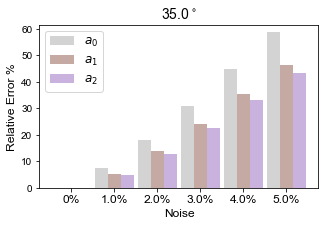

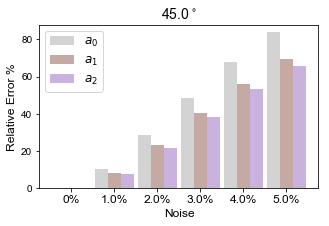

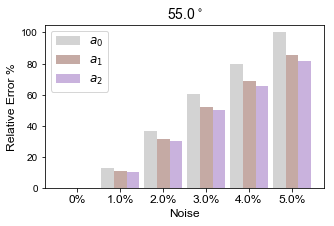

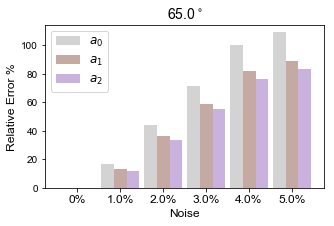

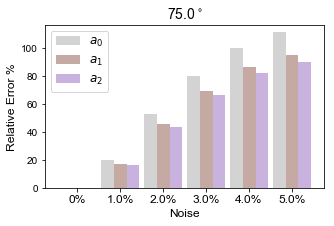

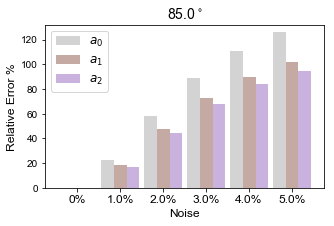

In [145]:
# Coefficients Relative Error
for i in range(len(T)):
    err_sol = sol_all_n[i,:]-solavg[i,:].T
    relative_error = np.abs(err_sol[:,:]*100 / solavg[i,:].reshape((-1)))
    # plot of the errors
    fig, ax = plt.subplots(figsize=(5,3))
    coef_label = ['$a_0$','$a_1$','$a_2$']

    ax.bar(np.arange(len(noise))[:]-0.3, relative_error[:,0],
            width = 0.3,
            color = 'darkgray',#'#9467bd',
            label = coef_label[0],
            align ='center',
            alpha=0.5,
            ecolor='black',
            capsize=14)
    ax.bar(np.arange(len(noise))[:]+0.0, relative_error[:,1],
            width = 0.3,
            color = '#8c564b',
            label = coef_label[1],
            align='center',
            alpha=0.5,
            ecolor='black',
            capsize=14)
    ax.bar(np.arange(len(noise))[:]+0.3, relative_error[:,2],
            width = 0.3,
            color = '#9467bd',
            label = coef_label[2],
            align='center',
            alpha=0.5,
            ecolor='black',
            capsize=14)
    ax.set_ylabel('Relative Error %',fontsize = 12)
    ax.set_xlabel('Noise', fontsize =12)
    ax.set_xticks(np.arange(len(noise)))
    ax.set_xticklabels([str(n*100)+'%' for n in noise], fontsize = 12)
#     ax.set_yticklabels(np.arange(0,15,2),fontsize=12)
    #     ax[i].set_yticks(np.arange(120))
    #     ax[i].set_yticklabels([str(e)+'%' for e in np.arange(12)],fontsize = 14)
    ax.set_title(str(T[i])+'$^\circ$C',fontsize = 14)
    ax.legend(fontsize = 12)